# Creating a mock data set for a prototype fraud detection algorithm

This notebook is intended to create a mock data set to develop and showcase a hybrid fraud detection algorithm based on a variety of analytics techniques. 

## Properties of the data set

In order to be able to work with a reasonably realistic data set, the set needs to be rich enough to allow some outliers because of the random sampling, as well as a large range of "market shares" (number of patients per healthcare institution, for example), a few different "specialisms" or reference groups (which should be clear from the set of procedures they bill) and a varying degree of deviation from the mean.

On the one hand, if outliers are put in by hand it should be easy to detect them as well, but we try to make sure to mimick realistic databases and will in the detection not "know" about what we put in. Of course, some of the variation that is built into the data set is just to show how some particular fraud detection models work. In a realistic setting, there should be a reason to implement such models (for example: is there a contract agreement or a reason from knowledge of the particular field of industry why a particular combination of procedures should not exist) and it may well be that in reality these models flag very few or even no suspects at all.

Here, we build a mock data set with the following properties:
- There are 500 service providers
- They each serve an average of 100 customers, with some distribution around that average.
- We create an artificial list of product codes that are a letter and a number combined. Different letters are different types of services and the numbers are an indication of how expensive/extensive/big/complicated they are. So two codes with the same letter but different numbers are similar products/services of varying difficulty and hence price.
- We construct a specialism for a service provider, which means that they prefer a different set of product codes over others. In some detection models we will compare only within such reference groups, and we will see how well we can recver them with analytics as well.
- Some product codes will work with fixed prices for services, some are varying (billing by the hour, for example) from one billing party to another.

We are assuming that data quality is fine, and that all fields in this database are always filled correctly. In realistic settings this may not always be the case, and some data quality checks or some missing data imputation must be done. As this depends very strongly on the company hosting the fraud detection algorithm, we here make the simplification of having complete, perfect data. We will summarize the data in one table. Note that this will also not be necessary or even possible in reality, but it is the simplest, cleanest case possible for a prototype algortihm. We also assume that this consist only of paid invoices, any declined bills are not taken into account. Adding declined billings could add some information, but using this in fraud detection is something that heavily depends on the machinery of a client and the rules by which they decide to pay or not. We do not take into account any free text fields on the invoices. Many companies don't even have these, and if they do it depends too heavily on the use of it to make a general example out of them (In case they are often used, fraud detection models based on text analytics can be made as well). The columns in the resulting data set will be:
- Unique customer identifier
- Unique service provider identifier
- Product code
- Paid amount
- Date of service
- Date of billing
- Pre-defined specialism (note that we may sometimes use this, and other times a reference group obtained from the data, which may or may not correspond)
- Provider bill or customer bill (which party did actually bill the company)

Relations will be generated between these properties for purposes of mimicking realistic billing patterns for an example of the healthare insurance industry and will be described where generated below. The dates of treatment will be chosen over the course of one year, billing may be delayed.

The data can be exported to any file format. As an example we dump a file to disk that can be efficiently read by the detection algorithm, but we will also export an example file to e.g. Excel, .csv or any human readable format. For purposes of communication this may also be an extract of the full data set.


# Description of the data - a healthcare example

Throughout the code, the data set is gradually built up and explains and shows the main features of the data.

We compile a set of treatments/procedures executed by a provider on a patient (who is insured by the company). Much of this is governed by the sampling of random numbers, from various distribution functions in order to ensure a realistic amount of complexity, as well as a common about of regularity that can be found in the billing data.

In [1]:
# Initialize the necessary software
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle, os, time, sys, itertools, string

%matplotlib inline

sns.set_context('talk')
sns.set_style('white')

rn.seed(42)

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
# di.display_html('''<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


In [2]:
# Parameter Initialization
n_prov = 500
n_pat_prov = 100

In [3]:
print('The number of providers in the data set will be', n_prov)
print('They will typically have about', n_pat_prov, 'patients each, with large variations.')

The number of providers in the data set will be 500
They will typically have about 100 patients each, with large variations.


In [4]:
patients_list = np.round(rn.lognormal(mean=np.log(n_pat_prov), sigma=0.5, size=n_prov))
n_patients = np.int(patients_list.sum())
# NUmber of visits for all of those people in a poisson distribution
n_visits = rn.poisson(0.3, n_patients)+1
print("Total number of patients and their visits in data base:", n_patients, np.int(n_visits.sum()))

Total number of patients and their visits in data base: 56809 73801


A visit is defined as the collection of treatments/procedures that are given to a patient on one day.

In the figure below, the distribution of the number of patients (or insurance members) of all care providers is shown. The variation may be due to practice/institution size, but also for example due to different market shares/coverages of the insurance company in different areas of the country.

The vertical dashed line indicates the limit of 50 patients per provider, which is often used in detection models to ensure reliable statistics. Note that this does not apply to all detection models, so for completeness we leave them in here as well.

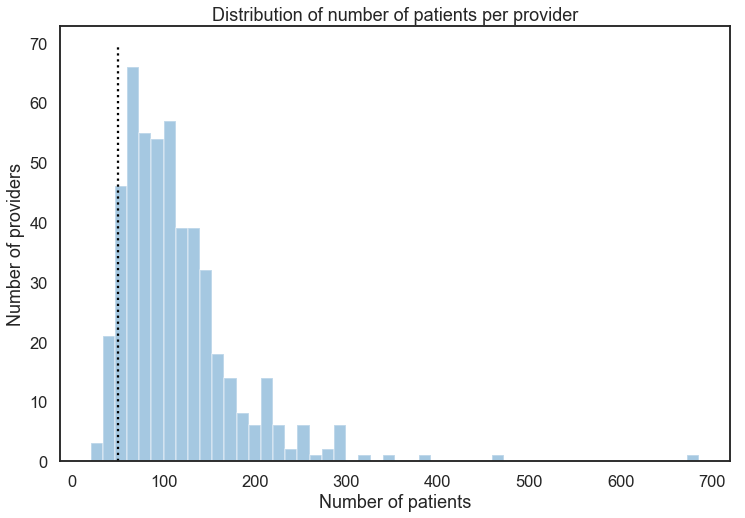

In [5]:
# rn.lognormal uses the mean and stdev of the underlying normal distribution, with natural logarithms
plt.figure(figsize=(12,8))
pp = sns.distplot(patients_list, bins=50, kde=False, norm_hist=False)
maxy = pp.get_ylim()[1]
pp.plot([50, 50], [0,maxy], "k:")
pp.set_xlabel("Number of patients")
pp.set_title("Distribution of number of patients per provider")
yl = pp.set_ylabel("Number of providers")

In [6]:
# Generate list of working days and a list of weeknds/holidays
# weekday 0 = monday
start_date = dt.datetime(2016, 1, 1).date()

weekdays = []
weekends = []

# Some well known holidays and some random holidays
holidays = [dt.datetime(2016, 1, 1).date(), 
            dt.datetime(2016, 12, 25).date(), 
            dt.datetime(2016, 8, 10).date(), 
            dt.datetime(2016, 11, 25).date()]

date = start_date
while date < dt.datetime(2017, 1, 1).date():
    if date.weekday() < 5 and date not in holidays: weekdays.append(date)
    else: weekends.append(date)
    date += dt.timedelta(days=1)

In [7]:
# Construct set of procedure codes
n_letters = 9

letters = list(string.ascii_uppercase[:n_letters])
# print(letters)

# Lets not make these random. First 4 come in three flavors, then some in two, then some fixed one, then variable one
n3 = 3
n2 = 3
n1 = 3

lengths = [3]*n3 + [2]*n2 + [1]*n1

procedure_codes = []
totlen = 0

for i, n in enumerate(letters):
    for j in range(lengths[i]): procedure_codes.append(n+str(j+1))

    totlen += lengths[i]

# print(procedure_codes)

price = [15, 25, 60, # A123
         23, 38, 75, # B123
         np.nan, np.nan, np.nan, # E123 free billing
         10, 15, 32, 48, # D12 E12
         np.nan, np.nan, # F12 free billing
         20, 34, np.nan] # GH1 I1 free billing

prices = {}
for ip, p in enumerate(price):
    prices[procedure_codes[ip]] = p

# print(prices)

In [8]:
# First assign fraud flags, reference groups to providers and 
# to each visit a member_ID, prov_ID and the two flags
p_fraud = .05
rn.seed(42)
fraud_prov = np.array([int(k) for k in rn.random(size=n_prov)/(1-p_fraud)])
n_fraudsters = np.int(fraud_prov.sum())

# Also assign a reference group (50, 40, 10 % of people)
refgroup_prov = [(1 if k<0.5 else 2 if k<0.8 else 3) for k in rn.random(size=n_prov)]

# Make a list of refgroup and fraud flag per visit
fraud = np.zeros(int(n_visits.sum()))
refgroup = np.zeros(int(n_visits.sum()))
prov_ID = np.zeros(int(n_visits.sum()))
member_ID = np.zeros(int(n_visits.sum()))

track_pat = 0
track_vis = 0
track_mem = 0
track_memvis = 0
for ip, num_pat in enumerate(patients_list):
    for patient in range(track_mem,track_mem+int(num_pat)):
        member_ID[track_memvis:track_memvis+int(n_visits[patient])] = np.ones(int(n_visits[patient])) * patient + 8000000
        track_memvis+=int(n_visits[patient])
        
    track_mem += int(num_pat)
    
    totvisits = n_visits[track_pat:track_pat+int(num_pat)].sum()
    fraud[track_vis:track_vis+int(totvisits)] = np.ones(totvisits)*fraud_prov[ip]
    refgroup[track_vis:track_vis+int(totvisits)] = np.ones(totvisits)*refgroup_prov[ip]
    prov_ID[track_vis:track_vis+int(totvisits)] = np.ones(totvisits)*ip + 1000000
    
    track_pat+=int(num_pat)
    track_vis+=int(totvisits)
    

In [9]:
# Assign a date to all visits - fraudsters have a 10% chance of also billing in weekends and holidays. 
# If they do, they do so often and they don't have the seasonal pattern
treatment_date = []
p_datefraud = 0.1
all_dates = weekdays*2+weekends*3
for fr in fraud:
    if fr and rn.random() < p_datefraud:
        treatment_date.append(rn.choice(all_dates))
    else: 
        day_to_add = rn.choice(weekdays)
        # Summer holiday correction
        if day_to_add.month in [7, 8] and rn.random() < .2:
            day_to_add += dt.timedelta(days=56)  # eight weeks later
        treatment_date.append(day_to_add)
        

        
# Some built-in fraud: Rising revenue, few gradual, few abrupt
# For gradual, move much of Jan to Dec, less from Feb to Nov, even less from Mar to Oct etc.
# For abrupt: pick a date for jump, move fixed, random fraction from before to after
treatment_date = np.array(treatment_date)
for i in range(10):
    frac_month = np.sqrt(rn.random())*.15  # in equal setps from 10% of visitis, to 190% for gradual growth at the strongest
    prov = rn.choice(prov_ID[fraud == 1])
    all_dates = treatment_date[prov_ID == prov]
    newdates = []
    for dat in all_dates:
        month = dat.month
        if month <=6:
            chance = .1 + frac_month*month
            if rn.random() > chance: 
                new_month = 13 - month
            else: new_month = month
        else: new_month = month
        newdates.append(dt.date(2016, new_month, np.abs(dat.day-4)+1))

    treatment_date[prov_ID == prov] = np.array(newdates)

for i in range(10):
    jump_date = start_date + dt.timedelta(days=rn.randint(180)+90)
    jump_frac = rn.random()*0.8
    prov = rn.choice(prov_ID[fraud == 1])
    all_dates = treatment_date[prov_ID == prov]
    newdates = []
    ndays = (start_date + dt.timedelta(days=365) - jump_date).days
    for dat in all_dates:
        if dat < jump_date and rn.random() < jump_frac:
            # If you jump, jump t a random date after the jump
            newdates.append(jump_date+dt.timedelta(days=rn.randint(ndays)))
        else: newdates.append(dat)

    treatment_date[prov_ID == prov] = np.array(newdates)


In [10]:
# Define probability density functions for all procedure code groups, per specialism

totnvisits = len(treatment_date)
prob_A_1 = list(rn.beta(5, 1, totnvisits)) # A is common for groups 1, 2, uncommon for 3
prob_A_2 = prob_A_1 
prob_A_3 = list(rn.beta(5, 1, totnvisits)/3)

prob_B_1 = list(rn.beta(5, 1, totnvisits)/3) # B is kinda common for groups 1, 2, very uncommon for 3
prob_B_2 = prob_B_1 
prob_B_3 = list(rn.beta(1, 5, totnvisits))

prob_C_1 = list(rn.beta(5, 1, totnvisits)/3) # C is kinda common for groups 1, 2, very uncommon for 3
prob_C_2 = prob_C_1 
prob_C_3 = list(rn.beta(1, 5, totnvisits))

prob_D_1 = list(rn.beta(5, 1, totnvisits)) # D is kinda common for group 1, 3, nonexistent for 2
prob_D_2 = [0]*totnvisits 
prob_D_3 = prob_D_1

prob_E_1 = list(rn.beta(1, 5, totnvisits)/3) # E is kinda common for group 2, very uncommon for 1,3
prob_E_2 = list(rn.beta(2, 2, totnvisits)) 
prob_E_3 = list(rn.beta(2, 2, totnvisits)/3)

prob_F_1 = list(rn.beta(2, 2, totnvisits)/3) # F is kinda common for group 2, very uncommon for 1,3
prob_F_2 = list(rn.beta(1, 5, totnvisits)) 
prob_F_3 = list(rn.beta(1, 5, totnvisits)/3)

prob_G_1 = list(rn.beta(1, 5, totnvisits)) # G is kinda common for group 3, 2, very uncommon for 1
prob_G_2 = list(rn.beta(2, 2, totnvisits)) 
prob_G_3 = list(rn.beta(5, 1, totnvisits))

prob_H_1 = list(rn.beta(1, 5, totnvisits)) # H is equaly kinda uncommon for all
prob_H_2 = list(rn.beta(1, 5, totnvisits)) 
prob_H_3 = list(rn.beta(1, 5, totnvisits))

prob_I_1 = [0]*totnvisits # I is kinda common for group 3, nonexistent 1,2
prob_I_2 = [0]*totnvisits 
prob_I_3 = list(rn.beta(5, 1, totnvisits))




An overview of the prices of different treatments are given below. Those with the same letter are supposed to be similar, medically, but different in either complexity or contract agreement. Some procedures are freely priced, which means they could be rates by the hours or something along those lines. In one visit, several treatments may be billed.

In [11]:
for c in procedure_codes: 
    if np.isnan(prices[c]): pp = "Free rates"
    else: pp = prices[c]
    print("Price of procedure code", c, ":", pp)

Price of procedure code A1 : 15
Price of procedure code A2 : 25
Price of procedure code A3 : 60
Price of procedure code B1 : 23
Price of procedure code B2 : 38
Price of procedure code B3 : 75
Price of procedure code C1 : Free rates
Price of procedure code C2 : Free rates
Price of procedure code C3 : Free rates
Price of procedure code D1 : 10
Price of procedure code D2 : 15
Price of procedure code E1 : 32
Price of procedure code E2 : 48
Price of procedure code F1 : Free rates
Price of procedure code F2 : Free rates
Price of procedure code G1 : 20
Price of procedure code H1 : 34
Price of procedure code I1 : Free rates


In [12]:
# Couple of methods for billing dates:
#     - 1. Last day of the month
#     - 2. End of the week
#     - 3. Few random large batches
#     - 4. random number of days after treatment

def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)  # this will never fail
    return next_month - dt.timedelta(days=next_month.day)

# That tyields:
# >>> for month in range(1, 13):
# ...     print last_day_of_month(datetime.date(2012, month, 1))
# ...
# 2012-01-31
# 2012-02-29
# 2012-03-31
# 2012-04-30
# 2012-05-31
# 2012-06-30
# 2012-07-31
# 2012-08-31
# 2012-09-30
# 2012-10-31
# 2012-11-30
# 2012-12-31


# Match a list of provider_ID - billing cycle
all_provs = np.unique(prov_ID)
billing_cycle = {}
batch_dates = {}  # Only relevant if cycle=3
for p in all_provs:
    billing_cycle[p] = rn.randint(1, 5)
    if billing_cycle[p] == 3:
        aantal = rn.randint(1,8)
        large_batch_dates = []
        for i in range(aantal-1):
            large_batch_dates.append(start_date + dt.timedelta(days=rn.randint(365)))
        large_batch_dates.append(start_date + dt.timedelta(days=rn.randint(365)+365))
        batch_dates[p] = np.sort(np.array(large_batch_dates))

# Set billing dates and billing party for all visits:
billing_date = []
billing_party = []
for ii, td in enumerate(treatment_date):
    prov = prov_ID[ii]
    c = billing_cycle[prov]
    if c == 1:
        billing_date.append(last_day_of_month(td))
        billing_party.append('Provider')
        
    elif c == 2:
        dow = td.weekday()
        # billing on day 4
        if dow <= 4: delta = 4-dow
        else: delta = 4+(7-dow)
        billing_date.append(td+dt.timedelta(days=delta))
        if rn.random() < 0.2: billing_party.append('Patient')
        else: billing_party.append('Provider')
        
    elif c == 3:
        batches = batch_dates[prov]
        billing_date.append(batch_dates[prov][batch_dates[prov] > td][0])
        billing_party.append('Provider')
        
    elif c == 4:
        delta = rn.randint(100)
        billing_date.append(td+dt.timedelta(days=delta))
        if rn.random() < 0.8: billing_party.append('Patient')
        else: billing_party.append('Provider')
            



Providers come in three specialisms, that can be seen as reference groups (behavior within the group should be much more similar than between groups). As such the chance that a given patient gets a certain procedure code is different for the different peer groups. 

Of the three specialisms, number 1 constitutes 50% of providers, while 30% have specialism 2 and the last 20% is of the third kind. The figure below shows the different mix of treatment groups. Within the procedure code groups, the distribution of the different subtypes is also different.


In [13]:
# Construct a helping list for deviating from the pre-defined specialism pattern
n_deviations = 30
un_prov = np.unique(prov_ID)
deviate_pattern = rn.choice(un_prov, size=n_deviations, replace=False)

In [14]:
# Take all visits and build a dataframe with treatments
max_n_treatments = n_letters*totnvisits

Member_ID = [0]*max_n_treatments
Provider_ID = [0]*max_n_treatments
Procedure_code = [0]*max_n_treatments
Paid_amt = [0.]*max_n_treatments
Treatment_date = [dt.date(2015, 12, 31)]*max_n_treatments
Billing_date = [dt.date(2015, 12, 31)]*max_n_treatments
Prov_specialism = [0]*max_n_treatments
Billing_party = ['0']*max_n_treatments
Procedure_letter = ['0']*max_n_treatments



# Loop over all visits and assign all the procedures, with all relevant quantities from the list above
track_treatment = 0
for visit, visit_date in enumerate(treatment_date):
    number_treats_prov = 0
    
    while number_treats_prov == 0:    # Just to make sure that every member gets SOMEthing
        for letter in letters:
            # Are we doing this one?
            expr = "rn.random() < prob_"+letter+"_"+str(int(refgroup[visit]))+".pop()"
            do = eval(expr)

            if do:
                # See if we want to make this one deviate
                rg = refgroup[visit]
                if prov_ID[visit] in deviate_pattern and rn.random() < .5:
                    if rn.random() > 0.5: rg = (rg + 1)%3 + 1
                    else: rg = (rg)%3 + 1
                    
                
                number_treats_prov += 1
                Member_ID[track_treatment] = int(member_ID[visit])
                Provider_ID[track_treatment] = int(prov_ID[visit])
                Treatment_date[track_treatment] = treatment_date[visit]
                Billing_date[track_treatment] = billing_date[visit]
                Prov_specialism[track_treatment] = int(refgroup[visit])
                Billing_party[track_treatment] = billing_party[visit]

                # Get the exact procedure code and the corresponding amount billed
                k = rn.random()
                if letter in ['A', 'B', 'C']: 
                    if rg != 3:
                        # For refgroup 1, 2, make it a 50, 40, 10 for 1, 2, 3
                        number_code = 1 if k<0.5 else 2 if k<0.9 else 3
                    else: 
                        # For refgroup 3, make it 20, 60, 20
                        number_code = 1 if k<0.2 else 2 if k<0.8 else 3

                elif letter in ['D', 'E', 'F']:
                    if rg != 2:
                        # For refgroup 1, 3 make it 70, 30 for 1, 2
                        number_code = 1 if k<0.7 else 2 
                    else:
                        # For refgroup 2 make it 10, 90 for 1, 2
                        number_code = 1 if k<0.1 else 2 

                else: number_code = 1

                Procedure_code[track_treatment] = letter+str(number_code)   
                Procedure_letter[track_treatment] = letter

                if not np.isnan(prices[Procedure_code[track_treatment]]): 
                    Paid_amt[track_treatment] = prices[Procedure_code[track_treatment]]
                else: 
                    if letter == 'I': Paid_amt[track_treatment] = np.round((rn.random()*200+50), 2)
                    else: Paid_amt[track_treatment] = np.round((rn.random()*100+50*number_code), 2)

                track_treatment += 1

    
Member_ID = np.array(Member_ID[:track_treatment])
Provider_ID = np.array(Provider_ID[:track_treatment])
Procedure_code = np.array(Procedure_code[:track_treatment])
Paid_amt = np.array(Paid_amt[:track_treatment])
Treatment_date = np.array(Treatment_date[:track_treatment])
Billing_date = np.array(Billing_date[:track_treatment])
Prov_specialism = np.array(Prov_specialism[:track_treatment])
Billing_party = np.array(Billing_party[:track_treatment])
Procedure_letter = np.array(Procedure_letter[:track_treatment])

In [15]:
# Before the payments are shown, build in some more fraudulent behavior.

totextra = 0
# Extra bill with random set of extra procedures, on top of gradual pattern for 10 providers
for iprov in range(10):
    prov_extra = 1000000 + rn.randint(500)
    bill_date_extra = rn.choice(all_dates)
    # Treatment_dates should be before billing date
    n_days = (bill_date_extra - start_date).days
    prov_spec = Prov_specialism[Provider_ID == prov_extra][0]
    # A loop over some number of patients:
    for ipat in range(rn.randint(40)):
        # A decent number to make it noticable
        n_treatments = rn.randint(5)
        # Treatments between start of year and billing date
        # Select a random patient of this one.
        patient = rn.choice(Member_ID[Provider_ID == prov_extra])
        date_extra = start_date + dt.timedelta(days=rn.randint(n_days))
        for treat in range(n_treatments):
            Member_ID = np.append(Member_ID, patient)
            Provider_ID = np.append(Provider_ID, prov_extra)
            pcode = rn.choice(procedure_codes)
            Procedure_code = np.append(Procedure_code, pcode)
            if not np.isnan(prices[pcode]):
                Paid_amt = np.append(Paid_amt, prices[pcode])
            else: Paid_amt = np.append(Paid_amt, np.round((rn.random()*100), 2))
            Treatment_date = np.append(Treatment_date, date_extra)
            Billing_date = np.append(Billing_date, bill_date_extra)
            Prov_specialism = np.append(Prov_specialism, prov_spec)
            Billing_party = np.append(Billing_party, "Provider")
            Procedure_letter = np.append(Procedure_letter, pcode[0])
            totextra+=1
    
# print("Added", totextra, "treatments for fraud inclusion.")
    


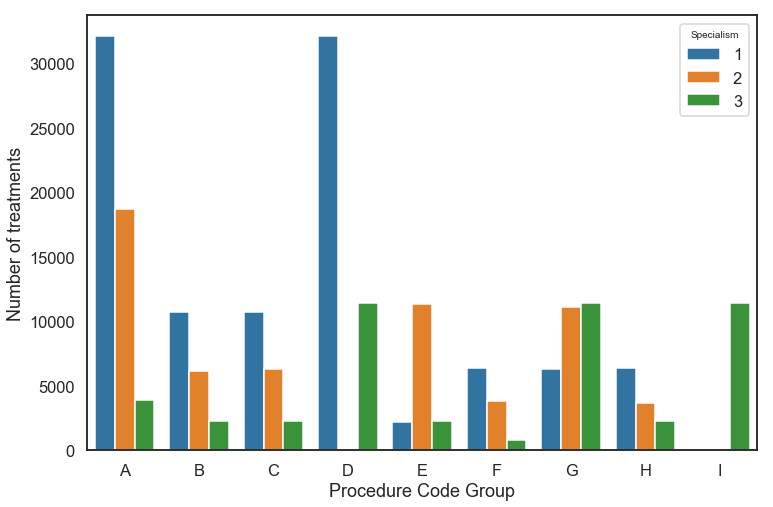

In [16]:
treatments = pd.DataFrame({'letter':Procedure_letter, 'Specialism':Prov_specialism})
counts = treatments.groupby(['Specialism', 'letter']).size()
cc = counts.reset_index()

plt.figure(figsize=(12,8))
pp = sns.barplot(x=cc.letter, y=cc[0], hue=cc.Specialism)
pp.set_xlabel('Procedure Code Group')
pp.set_ylabel('Number of treatments')
leg = pp.legend(loc='upper right', title='Specialism')

In [17]:
print("The data set contains a total of", len(Member_ID), "procedures carried out.")

The data set contains a total of 216153 procedures carried out.


Treatments are given mostly, but not only on weekdays. Some seasonal variation is built-in, such that in the summer months the use of care is a little lower, and in the months after summer it is a little higher than the average over the year. In weekends, and on 4 pre-defined holidays treatments are rare, but do happen.

In the figure below the total amount paid for treatments per day (thin blue line) and averaged over the week (thicker red line, the average assumes 5 working days a week) is shown. The variation around the averaged line is much larger on a individual health care provider basis is much larger, this is the smooth total of all health care providers. 

The date that is plotted is the treatment date, rather than the billing date, because treatment dates are much more smoothly distributed over the year. Billing from providers comes mostly in cycles, eiter at the end of the week, end of the month or in large batches spaced irregularly in time. Billing by patients happens in some random, but never very many, number of days after the treatment.

In [18]:
pay = pd.DataFrame({'Paid_amt':Paid_amt, 'Treatment_date':pd.to_datetime(Treatment_date)})
per_day = pay.groupby('Treatment_date')
Paid = per_day.Paid_amt.sum()

In [19]:
paid_week = Paid.resample('W-Wed').sum()

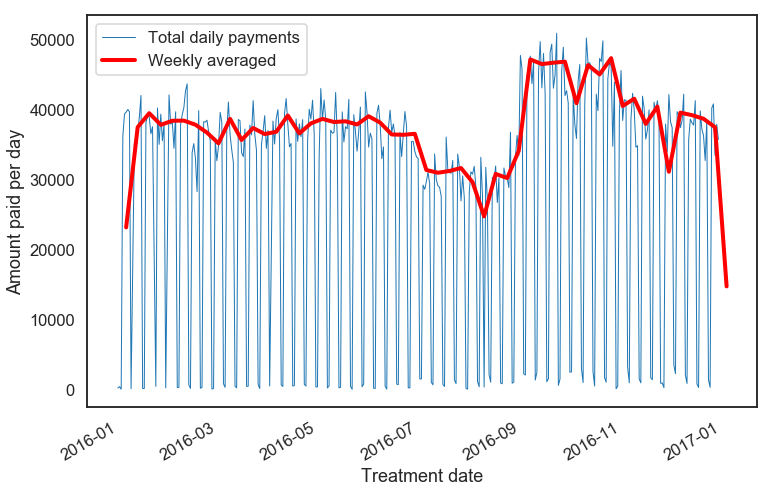

In [20]:
plt.figure(figsize=(12,8))
pp = Paid.plot(lw=1, label="Total daily payments")
pp.plot(paid_week/5, color='red', lw=4, label="Weekly averaged")
pp.set_ylabel("Amount paid per day")
pp.set_xlabel("Treatment date")
leg = pp.legend(loc='upper left')

Note that all these daily totals are made up out of different mixes of providers, with different mixes of specialisms, billing different treatments. The complexity of that mix is what will allow us to find deviant behavior of some of providers in the fraid detection models.

In [21]:
# Create output data set in xlsx and csv
path = './data/'

mock_data = pd.DataFrame({'Member_ID':Member_ID, 'Provider_ID':Provider_ID, 
                          'Procedure_code':Procedure_code, 'Paid_amt':Paid_amt, 
                          'Treatment_date':Treatment_date, 'Billing_date':Billing_date, 
                          'Prov_specialism':Prov_specialism, 'Billing_party':Billing_party})

In [22]:
writer = pd.ExcelWriter(path+'mock_healthcare.xlsx')
mock_data.to_excel(writer)
writer.save()
mock_data.to_csv(path+'mock_healthcare.csv')
pfile = open(path+'mock_healthcare.pickle', 'wb')
pickle.dump(mock_data, pfile)
pfile.close()

# Data products
The result of this notbook are a .csv and a .xlsx file with one line per procedure, and the columns as described above. Any other file format can readily be created.

It must be noted that this data product does not seem huge. The number of line, as well as the number of columns is kept to a minimum, in order to show the effectiveness of fraud detection models. Additional information will only allow for more detailed and precise fraud detection. We deliberately have chosen to not take into account the following information, that in reality will often be present in some form or other, and which can indeed help in fraud detection, but are so heavily convoluted in the real world, that it would be very difficult to realistically incoroporate it in a data set like the one presented here:
- Social network data: it is likely that lucrative billing behavior is shared among "friends" and the build up of a social network can sharpen fraud detection.
- Geographical information: location-based detection can help in case insurance members move houses, but also in peer group formulation (more specialized care is often consumed at larger distance from your house).
- Free text field on bills can help in supervised machine learning model where fraudulent claims are present in large numbers.

Fraud modeling for any customer will always require a lot of tuning of models and data, because not only the data warehouse, but more importanty also the market dynamics, contract structure and financial incentives to commit fraud will be vastly different. The models in the prototype are just one example of how this can work, and this data set is only meant to serve that goal.